In [1]:
from Functions1 import LoadData
from Functions1 import TestStrategy
from Functions1 import DynamicBacktest
import os
import pandas as pd
import yfinance as yf
import itertools
import random
import matplotlib.pyplot as plt
import quantstats as qs
from tqdm import tqdm
import numpy as np
import seaborn as sns

### Carga de datos

In [3]:
current_directory = os.getcwd()
path = os.path.join(current_directory, 'Stocks_financials')

loader = LoadData(path)
prices, financials = loader.Load(start_date='2005-09-01', end_date=None)

Data processed for the following tickers: AAPL, ADBE, ABNB, ABT, ACN, ADI, ADM, ADP, ADSK, AFL, AMAT, AMD, AMGN, AMT, AMZN, ANET, APH, AVGO, AXP, BA, BAC, BKNG, BLK, BMY, BRK-B, BSX, BX, C, CAT, CB, CL, CMCSA, COP, COST, CRM, CSCO, CTAS, CVX, DE, DELL, DHR, DIS, DOW, DUK, ELV, EQIX, ETN, FI, GE, GILD, GOOG, GOOGL, GS, HCA, HD, HON, IBM, ICE, INTC, INTU, ISRG, JNJ, JPM, KKR, KLAC, KO, LIN, LLY, LMT, LOW, LRCX, MCD, MCO, MDLZ, MDT, MMC, MMM, MO, MRK, MS, MSFT, MU, NEE, NFLX, NKE, NOW, NVDA, ORCL, PANW, PEP, PFE, PG, PGR, PLD, PLTR, QCOM, REGN, RTX, SBUX, SCHW, SHW, SO, SPGI, SRE, SYK, T, TGT, TJX, TMO, TSLA, TT, TXN, UBER, UNH, UNP, UPS, V, VMC, VRTX, VZ, WFC, WMT, XOM, ZBH
Datos descargados y guardados en prices.pkl


### Escenario unico

In [13]:
offensive_tickers = ["AMZN", "AAPL", "PM", 'V', 'NFLX',  'DUK', 'VZ', 'T', 'CVX', 'VMC', 'NVDA', 'GE', 'KO', 'JNJ', 'HD', 'AMD', 'ADM', 'TSLA', 'XOM']   
defensive_tickers = ['COST', 'DUK', 'JNJ', 'KO', 'LMT']      
canary_tickers = ['MSFT', 'V', 'NFLX', 'SO', 'DUK', 'PLD', 'VZ', 'T', 'CVX', 'VMC', 'NVDA', 'GE',
                      'KO', 'JNJ', 'GS', 'HD', 'AMD', 'ADM',  'GOOGL', 'TSLA', 'JPM', 'XOM', 'AAPL']    

In [15]:
strategy = TestStrategy(prices, financials, offensive_tickers, defensive_tickers, canary_tickers)
chosen_universe = strategy.run_strategy(start_date='2005-09-01')
chosen_universe.head(8)

,Date,Chosen Universe,Selected Stocks
0,2006-09-01,Defensive,"[COST, DUK, JNJ, KO, LMT]"
1,2007-03-01,Offensive,"[CVX, HD, ADM, XOM, AMZN, AAPL, NFLX, DUK]"
2,2007-09-01,Offensive,"[DUK, CVX, HD, XOM, ADM, AMZN, AAPL, NFLX]"
3,2008-03-01,Offensive,"[DUK, CVX, HD, XOM, ADM, AMZN, AAPL, NFLX]"
4,2008-09-01,Defensive,"[COST, DUK, JNJ, KO, LMT]"
5,2009-03-01,Defensive,"[COST, DUK, JNJ, KO, LMT]"
6,2009-09-01,Defensive,"[COST, DUK, JNJ, KO, LMT]"
7,2010-03-01,Offensive,"[T, CVX, JNJ, ADM, AMD, AMZN, AAPL, V]"


In [16]:
benchmark_df = yf.download('^GSPC', start=chosen_universe['Date'].min(), end=chosen_universe['Date'].max(), progress=False)
benchmark_data =  benchmark_df['Adj Close']

In [17]:
backtest = DynamicBacktest(results = chosen_universe , prices = prices, initial_capital = 1_000_000, benchmark_data=benchmark_data, benchmark_ticker='^GSPC')
port_values = backtest.get_portfolio_values()
port_values

,Sortino Portfolio Value,Benchmark Portfolio Value
2006-09-01,1.000000e+06,1.000000e+06
2006-09-02,1.000000e+06,1.000000e+06
2006-09-03,1.000000e+06,1.000000e+06
2006-09-04,1.000000e+06,1.000000e+06
2006-09-05,9.987625e+05,1.001709e+06
...,...,...
2024-08-26,1.427988e+07,4.284361e+06
2024-08-27,1.428703e+07,4.291195e+06
2024-08-28,1.416067e+07,4.265551e+06
2024-08-29,1.432408e+07,4.265383e+06


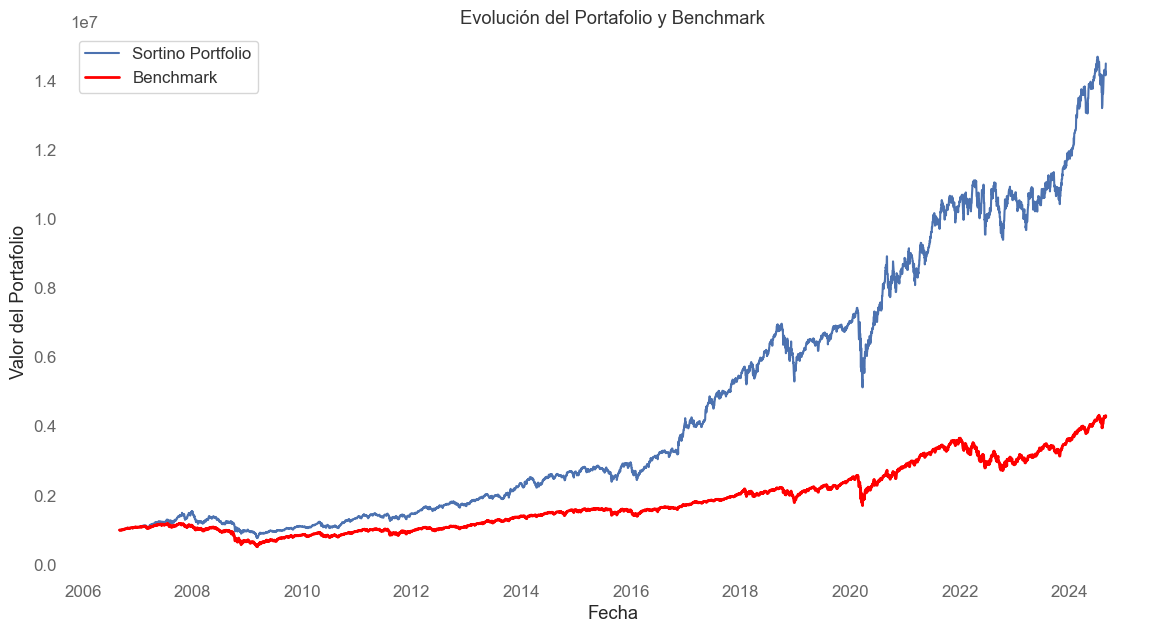

In [18]:
backtest.plot_strategies()

In [19]:
backtest.evaluate_portfolios()

,Strategy,Benchmark
CAGR,0.107970,0.057594
Sharpe Ratio,0.691585,0.508622
Sortino Ratio,1.001124,0.709640
Max Drawdown,-0.502686,-0.567754
Volatility,0.168852,0.198743
VaR (5%),-0.017032,-0.020192
Beta,0.826174,1.000000
Alpha,0.085265,0.000000


-------

### Simulaciones del metodo con Portafolios aleatorios

In [20]:
defensive_tickers

['COST', 'DUK', 'JNJ', 'KO', 'LMT']

In [23]:
universes = loader.beta(start_date="2005-09-01")

offensive_tickers = universes["offensive_universe"]   
defensive_tickers = universes["defensive_universe"]  

canary_tickers = [
    'AAPL', 'MSFT', 'NVDA', 'JPM', 'GS', 'XOM', 'CVX', 'TSLA', 'HD', 'AMZN', 'PG', 'KO', 'PEP', 
    'JNJ',  'CAT', 'HON', 'MMM', 'VZ', 'T', 'PLD', 'VMC', 'NEE', 'DUK'
]


Datos cargados desde el archivo prices.pkl


In [ ]:
#offensive_tickers = ['AAPL', 'ADM', 'ADSK', 'AMD', 'CAT', 'CRM', 'CVX', 'DE', 'DOW', 'GE', 'GOOGL', 'HD', 'HON',
#
#                     'MMM', 'MSFT', 'NFLX', 'NVDA', 'QCOM', 'RTX', 'TGT', 'TRYIY', 'TSLA', 'TXN', 'V', 'VMC', 'XOM']
#defensive_tickers = ['CL', 'COST', 'DUK', 'JNJ', 'KO', 'LMT', 'MCD', 'MDLZ', 'MRK', 'PG', 'SO','SRE', 'T', 'VZ', 'WMT', 'ZBH'] 


def generate_random_portfolios(tickers, n_tickers, n_portfolios):
    """
    Genera una lista de portafolios aleatorios con `n_tickers` tickers únicos en cada uno,
    permitiendo que los tickers puedan repetirse en distintos portafolios.

    Args:
    - tickers: Lista de tickers de la cual seleccionar.
    - n_tickers: Número de tickers únicos por portafolio.
    - n_portfolios: Número de portafolios a generar.

    Returns:
    - Una lista de portafolios, cada uno con `n_tickers` seleccionados aleatoriamente.
    """
    portfolios = []
    for _ in range(n_portfolios):
        portfolio = random.sample(tickers, n_tickers)
        portfolios.append(portfolio)
    return portfolios


n_portfolios = 1500
offensive_portfolios = generate_random_portfolios(offensive_tickers, 16, n_portfolios)
defensive_portfolios = generate_random_portfolios(defensive_tickers, 5, n_portfolios)

benchmark_df = yf.download('^GSPC', start='2005-09-01', end=None, progress=False)
benchmark_data = benchmark_df['Adj Close']

results = []


with tqdm(total=n_portfolios, desc="Simulating Portfolios", unit="portfolio") as pbar:
    for offensive_combo, defensive_combo in zip(offensive_portfolios, defensive_portfolios):
        try:
            
            strategy = TestStrategy(prices, financials, list(offensive_combo), list(defensive_combo), canary_tickers)
            chosen_universe = strategy.run_strategy(start_date='2005-09-01')

            
            backtest = DynamicBacktest(
                results=chosen_universe, prices=prices, initial_capital=1_000_000, 
                benchmark_data=benchmark_data, benchmark_ticker='^GSPC'
            )

            
            evaluation = backtest.evaluate_portfolios()
            
            
            strategy_metrics = evaluation['Strategy']
            
            
            results.append({
                'Offensive Combination': offensive_combo,
                'Defensive Combination': defensive_combo,
                'CAGR': strategy_metrics.get('CAGR', np.nan),
                'Sharpe Ratio': strategy_metrics.get('Sharpe Ratio', np.nan),
                'Sortino Ratio': strategy_metrics.get('Sortino Ratio', np.nan),
                'Max Drawdown': strategy_metrics.get('Max Drawdown', np.nan),
                'Volatility': strategy_metrics.get('Volatility', np.nan),
                'VaR (5%)': strategy_metrics.get('VaR (5%)', np.nan),
                'Beta': strategy_metrics.get('Beta', np.nan)
            })

        except Exception as e:
            print(f"Error with offensive {offensive_combo} and defensive {defensive_combo}: {str(e)}")
        
        
        pbar.update(1)


final_results_df = pd.DataFrame(results)

average_metrics = final_results_df[['CAGR', 'Sharpe Ratio', 'Sortino Ratio', 'Max Drawdown', 'Volatility', 'VaR (5%)', 'Beta']].mean()

Simulating Portfolios:   0%|          | 3/1500 [01:12<9:59:42, 24.04s/portfolio] 

In [18]:
final_results_df

,Offensive Combination,Defensive Combination,CAGR,Sharpe Ratio,Sortino Ratio,Max Drawdown,Volatility,VaR (5%),Beta
0,"(AAPL, ADSK, CAT, CRM, CVX, DOW, GE, GOOGL, HO...","(CL, MRK, SO, T, ZBH)",0.093376,0.593583,0.852992,-0.502320,0.176696,-0.017892,0.921785
1,"(ADM, ADSK, CAT, CVX, DOW, GE, HON, MMM, MSFT,...","(CL, DUK, SO, T, ZBH)",0.113911,0.674363,0.971292,-0.504659,0.185494,-0.018724,0.925511
2,"(AAPL, CAT, CRM, CVX, GE, GOOGL, HD, HON, MMM,...","(CL, KO, MRK, PG, SO)",0.105474,0.675946,0.974642,-0.423117,0.169637,-0.017122,0.890271
3,"(AMD, CAT, CRM, GE, GOOGL, HD, HON, MMM, NVDA,...","(DUK, LMT, MCD, MRK, PG)",0.112780,0.681450,0.976214,-0.486757,0.180861,-0.018251,0.951908
4,"(AMD, CAT, DE, DOW, GE, GOOGL, HD, HON, MSFT, ...","(CL, COST, SO, SRE, ZBH)",0.096372,0.607646,0.865416,-0.524268,0.177327,-0.017946,0.948033
5,"(AAPL, ADM, ADSK, CRM, CVX, DOW, GOOGL, HD, HO...","(KO, MCD, MRK, PG, SO)",0.098478,0.626679,0.893045,-0.493100,0.174091,-0.017606,0.869498
6,"(AAPL, ADM, ADSK, AMD, CAT, DOW, GE, GOOGL, HD...","(CL, LMT, MDLZ, MRK, T)",0.100404,0.629657,0.894543,-0.542109,0.176820,-0.017880,0.950958
7,"(AAPL, ADM, CRM, DE, DOW, GE, HD, HON, MMM, MS...","(COST, JNJ, LMT, PG, ZBH)",0.106234,0.673457,0.962864,-0.570327,0.171882,-0.017350,0.915545
8,"(ADM, ADSK, AMD, CAT, CRM, GE, GOOGL, HON, MMM...","(DUK, MCD, MRK, SO, T)",0.111593,0.665214,0.956225,-0.493690,0.184709,-0.018651,0.956951
9,"(AAPL, AMD, CRM, HD, HON, MSFT, NFLX, NVDA, QC...","(CL, COST, MCD, MDLZ, PG)",0.150129,0.842830,1.225564,-0.448497,0.186638,-0.018715,0.926659


In [14]:
average_metrics

CAGR             0.100904
Sharpe Ratio     0.619813
Sortino Ratio    0.889828
Max Drawdown    -0.492105
Volatility       0.179984
VaR (5%)        -0.018204
Beta             0.915353
dtype: float64

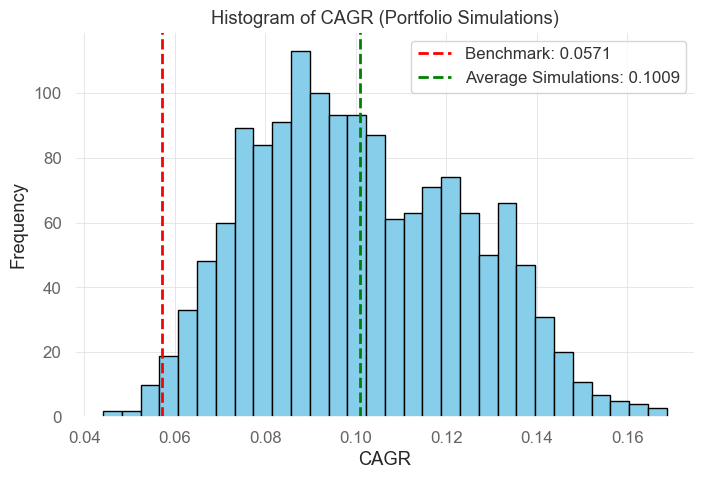

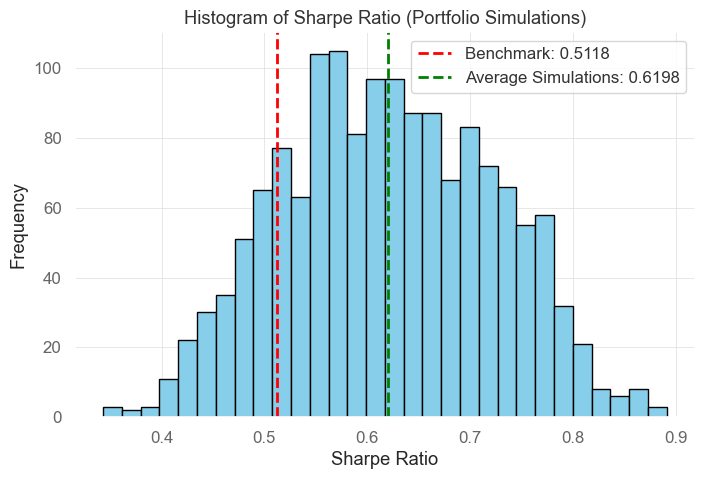

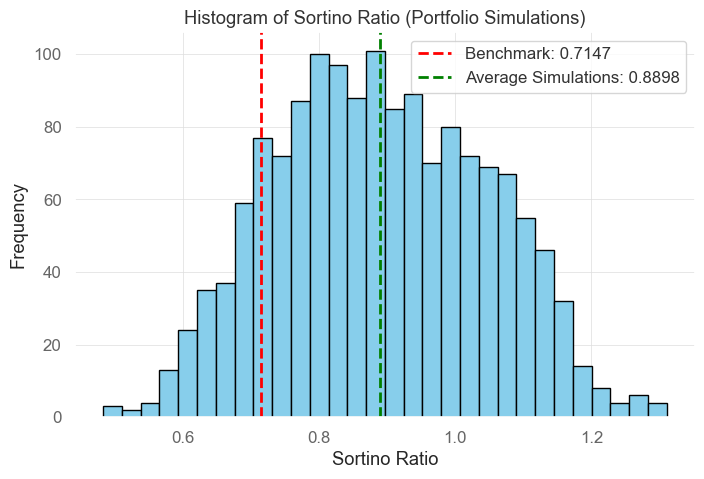

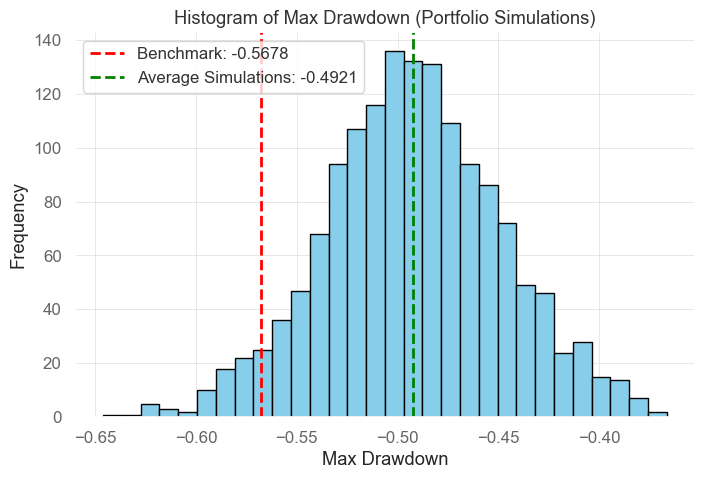

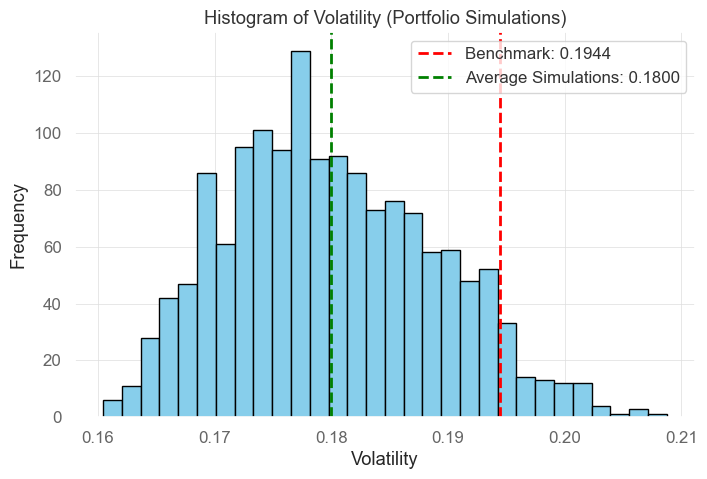

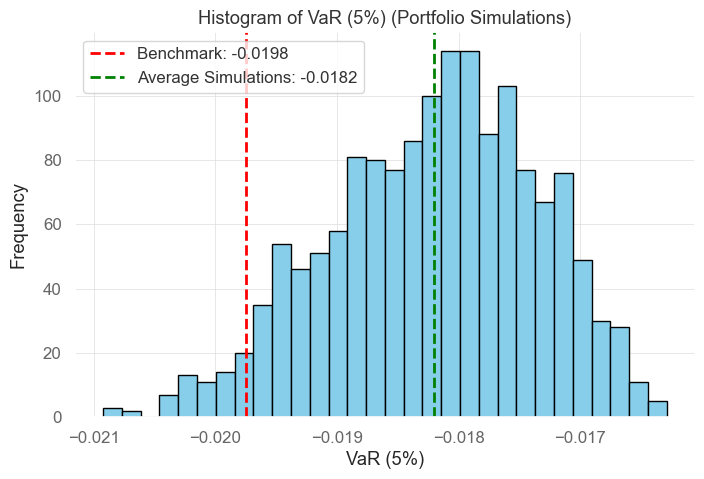

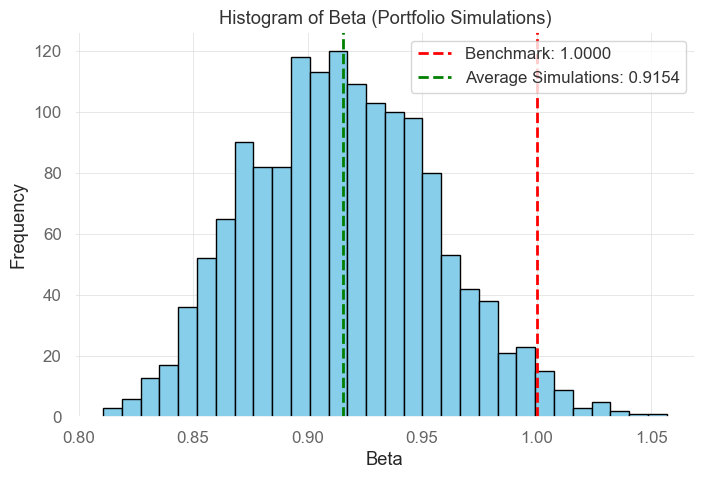

In [16]:
benchmark_evaluation = backtest.evaluate_portfolios()
benchmark_metrics = benchmark_evaluation['Benchmark'].to_dict()  

average_metrics = final_results_df[['CAGR', 'Sharpe Ratio', 'Sortino Ratio', 'Max Drawdown', 'Volatility', 'VaR (5%)', 'Beta']].mean()


important_columns = ['CAGR', 'Sharpe Ratio', 'Sortino Ratio', 'Max Drawdown', 'Volatility', 'VaR (5%)', 'Beta']


for column in important_columns:
    plt.figure(figsize=(8, 5))
    plt.hist(final_results_df[column].dropna(), bins=30, color='skyblue', edgecolor='black')
    
    # Línea vertical para el valor del benchmark
    benchmark_value = benchmark_metrics.get(column)
    if benchmark_value is not None:
        plt.axvline(benchmark_value, color='red', linestyle='dashed', linewidth=2, label=f'Benchmark: {benchmark_value:.4f}')
    
    # Línea vertical para el promedio de las simulaciones
    average_value = average_metrics.get(column)
    if average_value is not None:
        plt.axvline(average_value, color='green', linestyle='dashed', linewidth=2, label=f'Average Simulations: {average_value:.4f}')
    
    plt.title(f'Histogram of {column} (Portfolio Simulations)')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    
    plt.show()


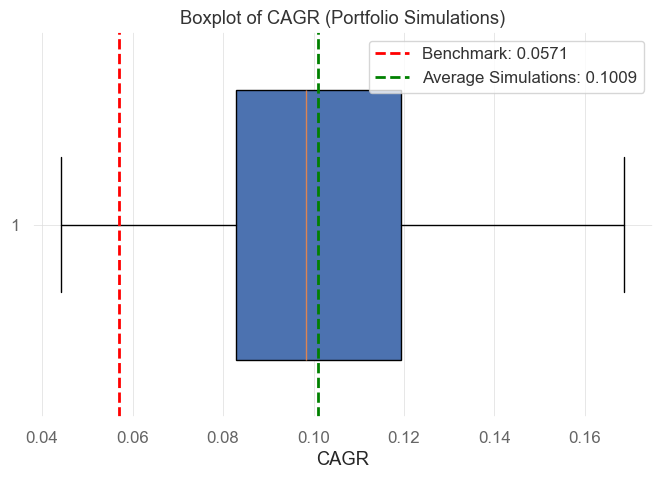

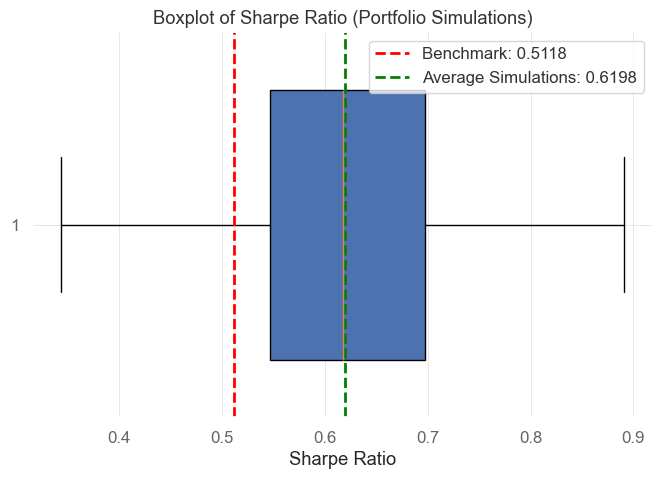

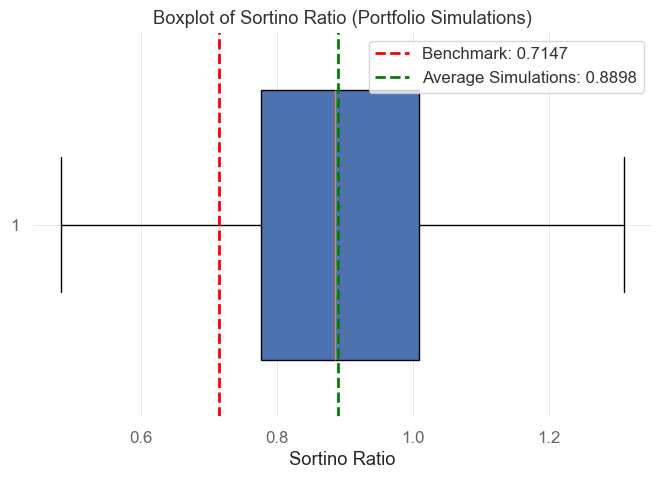

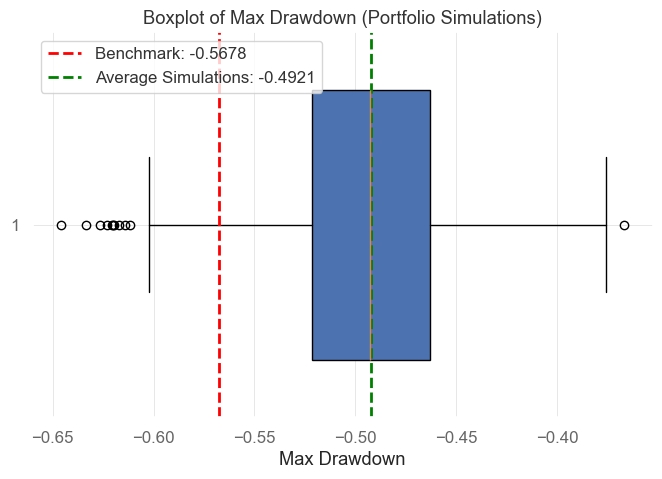

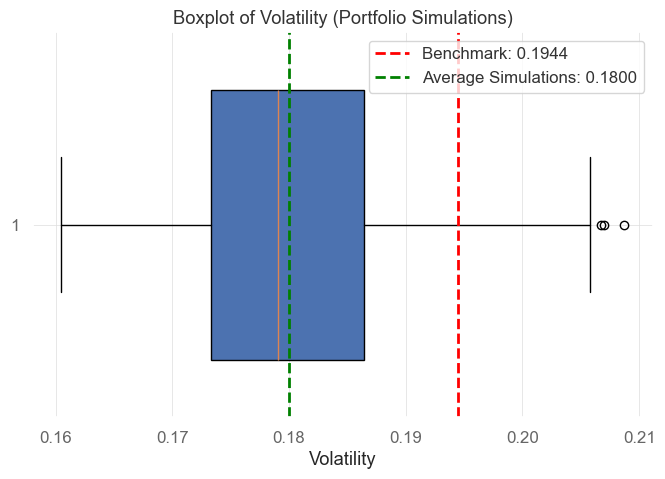

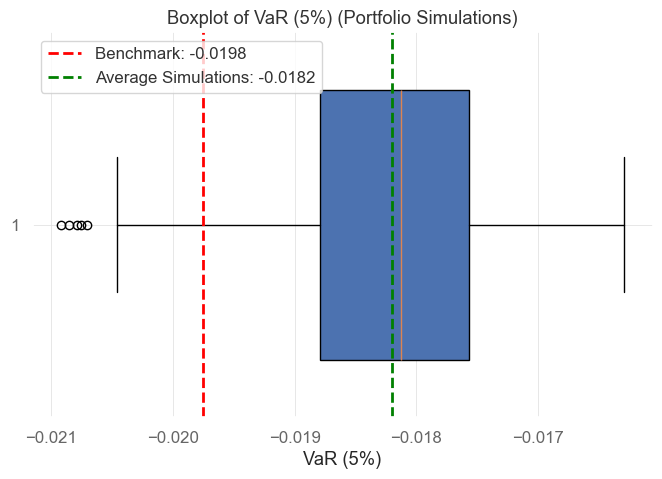

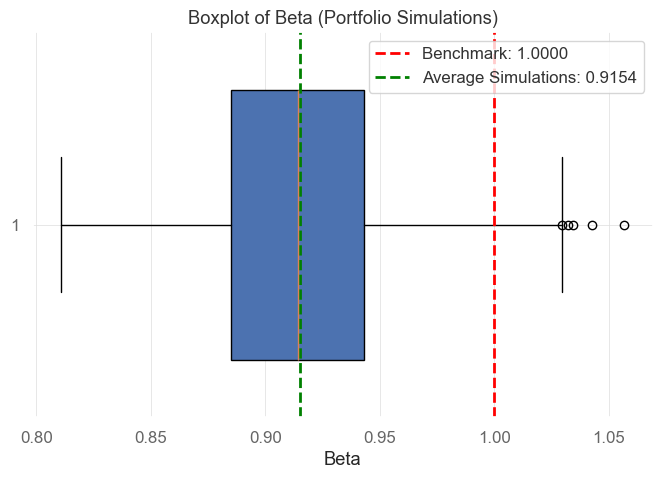

In [17]:
for column in important_columns:
    plt.figure(figsize=(8, 5))
    plt.boxplot(final_results_df[column].dropna(), vert=False, widths=0.7, patch_artist=True)
    
    # Línea vertical para el valor del benchmark
    benchmark_value = benchmark_metrics.get(column)
    if benchmark_value is not None:
        plt.axvline(benchmark_value, color='red', linestyle='dashed', linewidth=2, label=f'Benchmark: {benchmark_value:.4f}')
    
    # Línea vertical para el promedio de las simulaciones
    average_value = average_metrics.get(column)
    if average_value is not None:
        plt.axvline(average_value, color='green', linestyle='dashed', linewidth=2, label=f'Average Simulations: {average_value:.4f}')
    
    plt.title(f'Boxplot of {column} (Portfolio Simulations)')
    plt.xlabel(column)
    plt.legend()
    plt.grid(True)
    plt.show()


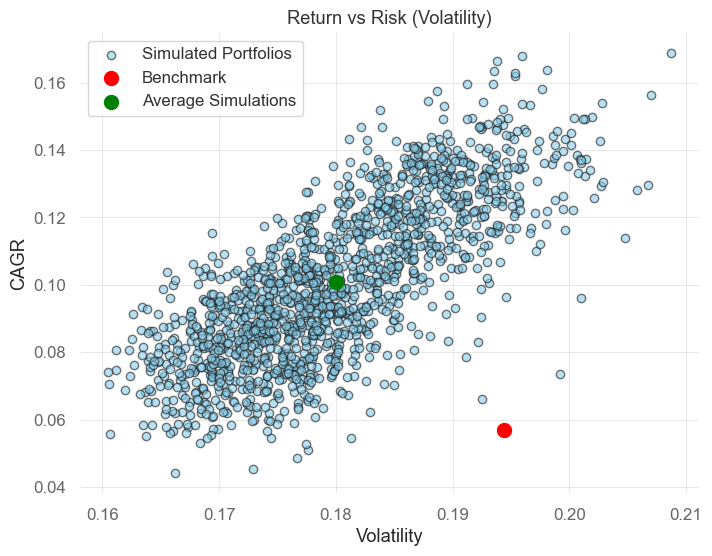

In [19]:
plt.figure(figsize=(8, 6))
plt.scatter(final_results_df['Volatility'], final_results_df['CAGR'], alpha=0.6, color='skyblue', edgecolor='k', label='Simulated Portfolios')

plt.scatter(benchmark_metrics['Volatility'], benchmark_metrics['CAGR'], color='red', s=100, label='Benchmark')

average_volatility = final_results_df['Volatility'].mean()
average_cagr = final_results_df['CAGR'].mean()

plt.scatter(average_volatility, average_cagr, color='green', s=100, label='Average Simulations')

plt.title('Return vs Risk (Volatility)')
plt.xlabel('Volatility')
plt.ylabel('CAGR')
plt.legend()
plt.grid(True)
plt.show()


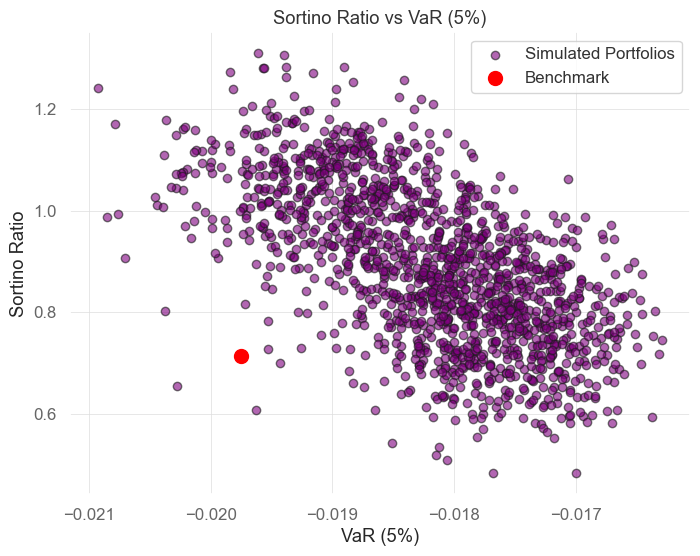

In [22]:
plt.figure(figsize=(8, 6))
plt.scatter(final_results_df['VaR (5%)'], final_results_df['Sortino Ratio'], alpha=0.6, color='purple', edgecolor='k', label='Simulated Portfolios')


plt.scatter(benchmark_metrics['VaR (5%)'], benchmark_metrics['Sortino Ratio'], color='red', s=100, label='Benchmark')

plt.title('Sortino Ratio vs VaR (5%)')
plt.xlabel('VaR (5%)')
plt.ylabel('Sortino Ratio')
plt.legend()
plt.grid(True)
plt.show()


--------

In [28]:
prices['META']

Date
2012-05-18     38.230000
2012-05-21     34.029999
2012-05-22     31.000000
2012-05-23     32.000000
2012-05-24     33.029999
                 ...    
2024-10-22    582.010010
2024-10-23    563.690002
2024-10-24    567.780029
2024-10-25    573.250000
2024-10-28    579.229980
Name: Close, Length: 3131, dtype: float64

In [33]:
ratios_to_check = [
    'Return on Common Equity',
    'Operating Margin',
    'Cash Flow per Share',
    'Current Ratio (x)',
    'Total Debt/Equity (%)',
    'Total Shares Outstanding  (M)',
    'Price/Earnings'
]

tickers_with_all_ratios = []

for ticker, df in financials.items():
    if all(ratio in df['Financial Ratio'].values for ratio in ratios_to_check):
        tickers_with_all_ratios.append(ticker)

tickers_with_all_ratios

['AAPL',
 'ABBV',
 'ADBE',
 'ABNB',
 'ABT',
 'ADI',
 'ADM',
 'ADP',
 'ADSK',
 'AMAT',
 'AMD',
 'AMGN',
 'ANET',
 'APH',
 'BA',
 'BMY',
 'BSX',
 'CAT',
 'CL',
 'COP',
 'CRM',
 'CSCO',
 'CTAS',
 'DE',
 'DELL',
 'DHR',
 'DIS',
 'DOW',
 'DUK',
 'GE',
 'GILD',
 'GOOGL',
 'HCA',
 'HON',
 'INTC',
 'JNJ',
 'KO',
 'LIN',
 'LLY',
 'LMT',
 'LOW',
 'MCD',
 'MDLZ',
 'MDT',
 'MMM',
 'MO',
 'MRK',
 'NEE',
 'NFLX',
 'NOW',
 'NVDA',
 'ORCL',
 'PANW',
 'PEP',
 'PFE',
 'PG',
 'PLTR',
 'PM',
 'QCOM',
 'REGN',
 'RTX',
 'SHW',
 'SO',
 'SPGI',
 'SRE',
 'SYK',
 'T',
 'TGT',
 'TJX',
 'TRYIY',
 'TSLA',
 'TT',
 'TXN',
 'UBER',
 'UNP',
 'UPS',
 'V',
 'VMC',
 'VRTX',
 'ZBH']

In [15]:
offensive_tickers

['MSFT',
 'AAPL',
 'GOOGL',
 'V',
 'NFLX',
 'SO',
 'DUK',
 'VZ',
 'T',
 'CVX',
 'VMC',
 'NVDA',
 'GE',
 'KO',
 'JNJ',
 'HD',
 'AMD',
 'ADM',
 'META',
 'TSLA',
 'XOM']

In [41]:
all_tickers = [
    "AAPL", "ABBV", "ADBE", "ABNB", "ABT", "ADI", "ADM", "ADP", "ADSK", "AFL", 
    "AMAT", "AMD", "AMGN", "AMZN", "ANET", "APH", "AXP", "BA", "BAC", "BLK", 
    "BMY", "BSX", "BX", "C", "CAT", "CB", "CL", "CMCSA", "COP", "COST", "CRM", 
    "CSCO", "CTAS", "CVX", "DE", "DELL", "DHR", "DIS", "DOW", "DUK", "ELV", 
    "GE", "GILD", "GOOG", "GOOGL", "GS", "HCA", "HD", "HON", "INTC", "JNJ", 
    "JPM", "KO", "LIN", "LLY", "LMT", "LOW", "MCD", "MDLZ", "MDT", "META", 
    "MMC", "MMM", "MO", "MRK", "MS", "MSFT", "NEE", "NFLX", "NOW", "NVDA", 
    "ORCL", "PANW", "PEP", "PFE", "PG", "PGR", "PLD", "PLTR", "PM", "QCOM", 
    "REGN", "RTX", "SCHW", "SHW", "SO", "SPGI", "SRE", "SYK", "T", "TGT", 
    "TJX", "TRYIY", "TSLA", "TT", "TXN", "UBER", "UNH", "UNP", "UPS", "V", 
    "VMC", "VRTX", "VZ", "WFC", "WMT", "XOM", "ZBH"
]


tickers_without_all_ratios = [ticker for ticker in offensive_tickers if ticker not in tickers_with_all_ratios]
tickers_without_all_ratios

['MSFT', 'VZ', 'CVX', 'HD', 'META', 'XOM']

In [19]:
final_offensive = [elemento for elemento in offensive_tickers if elemento not in tickers_without_all_ratios]

In [27]:
tickers_to_check = [
    'ABBV', 'CL', 'COST', 'DUK', 'JNJ', 'KO', 'LMT', 'MCD', 'MDLZ', 'MRK', 
    'PG', 'SO', 'SRE', 'T', 'VZ', 'WMT', 'ZBH'
]

tickers_with_initial_date = []

for ticker in tickers_to_check:
    first_date = pd.to_datetime(prices[ticker].index[0])
    
    if first_date == pd.to_datetime('2005-09-01'):
        tickers_with_initial_date.append(ticker)

tickers_with_initial_date

['CL',
 'COST',
 'DUK',
 'JNJ',
 'KO',
 'LMT',
 'MCD',
 'MDLZ',
 'MRK',
 'PG',
 'SO',
 'SRE',
 'T',
 'VZ',
 'WMT',
 'ZBH']

In [29]:
missing_tickers = [ticker for ticker in canary_tickers if ticker not in all_tickers]

missing_tickers

[]

In [ ]:
current_directory = os.getcwd()
path = os.path.join(current_directory, 'Stocks_financials')

loader = LoadData(path)
prices, financials = loader.Load(start_date='2005-09-01', end_date=None)

offensive_tickers = ["MSFT", "AAPL", "GOOGL", 'V', 'NFLX', 'SO', 'DUK', 'VZ', 'T', 'CVX', 'VMC', 'NVDA', 'GE', 'KO', 'JNJ', 'HD', 'AMD', 'ADM', 'META', 'TSLA', 'XOM']   
defensive_tickers = ['COST', 'DUK', 'JNJ', 'KO', 'LMT']      
canary_tickers = ['MSFT', 'V', 'NFLX', 'SO', 'DUK', 'PLD', 'VZ', 'T', 'CVX', 'VMC', 'NVDA', 'GE',
                      'KO', 'JNJ', 'GS', 'HD', 'AMD', 'ADM', 'META', 'GOOGL', 'TSLA', 'JPM', 'XOM', 'AAPL']    

strategy = TestStrategy(prices, financials, offensive_tickers, defensive_tickers, canary_tickers)
chosen_universe = strategy.run_strategy(start_date='2005-09-01')

benchmark_df = yf.download('^GSPC', start=chosen_universe['Date'].min(), end=chosen_universe['Date'].max(), progress=False)
benchmark_data =  benchmark_df['Adj Close']

backtest = DynamicBacktest(results = chosen_universe , prices = prices, initial_capital = 1_000_000, benchmark_data=benchmark_data, benchmark_ticker='^GSPC')
backtest.plot_strategies()
backtest.evaluate_portfolios().T